<a href="https://colab.research.google.com/github/Jagoda222/LoLa---group-8/blob/main/sentence_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports





In [1]:
!pip install accelerate -U
!pip install datasets==2.14.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 871.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver 

In [14]:
import torch
import pandas as pd
from os import path as op
import os
import numpy as np
from collections import Counter
import datasets
from datasets import load_dataset, load_metric, concatenate_datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt


# GPT2:
## Working on the ordering by the sentence length

Total time of running: +/- 5min

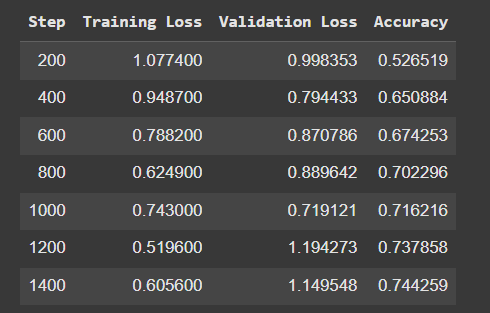
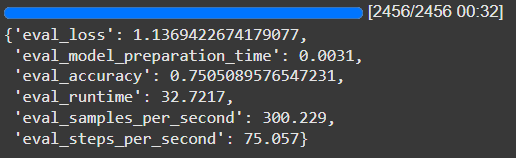

In [15]:
# META Variables
# it is good to have certain directories for saving model checkpoints (e.g., on google drive)
MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "gpt2"
BATCH_SIZE = 16
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
metric = load_metric('glue', "mnli")
tokenizer.pad_token = tokenizer.eos_token

In [27]:
def add_sentence_length(example):
    combined_text = example['premise'] + " " + example['hypothesis']
    example['sentence_length'] = len(combined_text.split())  # Word count
    return example

snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))

# SNLI data needs to be cleaned as it contains -1s as a label
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )

# https://huggingface.co/transformers/preprocessing.html
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)

Counter({0: 183416, 2: 183187, 1: 182764, -1: 785})
DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
})


In [18]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
snli_data["train"] = snli_data["train"].map(add_sentence_length)


In [22]:
short_sentences = snli_data["train"].filter(lambda x: x['sentence_length'] < 15).shuffle(seed=42).select(range(667))
medium_sentences = snli_data["train"].filter(lambda x: 15 <= x['sentence_length'] < 25).shuffle(seed=42).select(range(666))
long_sentences = snli_data["train"].filter(lambda x: x['sentence_length'] >= 25).shuffle(seed=42).select(range(667))

# Combine sampled rows
diverse_sentences = concatenate_datasets([short_sentences, medium_sentences, long_sentences])

# Print the result
print(diverse_sentences)
print(f"Total rows: {len(diverse_sentences)}")

# Verify sentence length distribution
print("Sentence Length Distribution:")
print([row.get('sentence_length', None) for row in diverse_sentences])  # Use .get to safely access the key


Dataset({
    features: ['premise', 'hypothesis', 'label', 'sentence_length'],
    num_rows: 2000
})
Total rows: 2000
Sentence Length Distribution:
[10, 13, 12, 13, 13, 14, 11, 11, 9, 12, 12, 14, 14, 14, 13, 12, 13, 14, 13, 12, 13, 11, 10, 13, 11, 13, 14, 12, 12, 10, 11, 9, 14, 9, 10, 13, 11, 11, 14, 11, 13, 11, 12, 14, 10, 14, 13, 13, 14, 13, 13, 9, 14, 13, 13, 12, 14, 13, 11, 14, 14, 9, 11, 14, 13, 10, 12, 13, 12, 14, 14, 14, 12, 12, 11, 11, 10, 13, 11, 10, 14, 11, 13, 10, 12, 12, 12, 13, 12, 11, 14, 11, 13, 13, 14, 14, 12, 14, 12, 12, 14, 14, 13, 12, 13, 14, 14, 10, 13, 13, 14, 8, 14, 8, 12, 13, 11, 12, 14, 14, 13, 14, 12, 10, 10, 12, 13, 12, 11, 10, 14, 14, 14, 14, 14, 13, 10, 12, 9, 13, 14, 14, 14, 13, 13, 14, 14, 13, 11, 10, 12, 14, 12, 10, 12, 10, 14, 10, 13, 12, 11, 12, 12, 12, 13, 14, 11, 13, 9, 14, 14, 13, 14, 14, 12, 12, 13, 11, 13, 13, 14, 11, 14, 14, 13, 13, 13, 14, 12, 14, 13, 12, 10, 12, 11, 14, 14, 14, 14, 14, 14, 14, 11, 12, 13, 11, 13, 13, 13, 14, 13, 13, 11, 14, 13, 

In [26]:
encoded_diverse_sentences = diverse_sentences.map(
    preprocess_function,
    batched=True,                # Tokenize multiple rows in parallel
    load_from_cache_file=False   # Ensures preprocessing runs fresh
)

# Verify tokenization output
print(encoded_diverse_sentences[0])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'premise': 'Workers dig around a house.', 'hypothesis': 'The workers are planting trees.', 'label': 1, 'sentence_length': 10, 'input_ids': [12468, 364, 3100, 1088, 257, 2156, 13, 464, 3259, 389, 26630, 7150, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [28]:

# Step 2: Preprocess the sorted data

encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    output_dir=MODEL_DIR,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_dir="./logs",
)

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
print(encoded_snli_data['train'][0])

{'premise': 'A person on a horse jumps over a broken down airplane.', 'hypothesis': 'A person is training his horse for a competition.', 'label': 1, 'input_ids': [32, 1048, 319, 257, 8223, 18045, 625, 257, 5445, 866, 19401, 13, 32, 1048, 318, 3047, 465, 8223, 329, 257, 5449, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [24]:
train_df = pd.DataFrame(snli_data["train"])

# Plot a histogram of sentence lengths
plt.figure(figsize=(8, 5))
plt.hist(train_df['sentence_length'], bins=30, edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length (Word Count)")
plt.ylabel("Frequency")
plt.show()

# Basic statistics about sentence lengths
print(train_df['sentence_length'].describe())

KeyboardInterrupt: 

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_diverse_sentences,
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-32-426f16effd4a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy
200,1.077400,0.998353,0.526519
400,0.948700,0.794433,0.650884
600,0.788200,0.870786,0.674253
800,0.624900,0.889642,0.702296
1000,0.743000,0.719121,0.716216
1200,0.519600,1.194273,0.737858
1400,0.605600,1.149548,0.744259


TrainOutput(global_step=1500, training_loss=0.7696232096354166, metrics={'train_runtime': 499.3651, 'train_samples_per_second': 12.015, 'train_steps_per_second': 3.004, 'total_flos': 104787067262976.0, 'train_loss': 0.7696232096354166, 'epoch': 3.0})

In [33]:
# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_diverse_sentences,
    eval_dataset=encoded_snli_data["test"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()

<ipython-input-33-f176052f2637>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_eval = Trainer(


{'eval_loss': 1.1369422674179077,
 'eval_model_preparation_time': 0.0031,
 'eval_accuracy': 0.7505089576547231,
 'eval_runtime': 32.7217,
 'eval_samples_per_second': 300.229,
 'eval_steps_per_second': 75.057}